In [57]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.ticker import PercentFormatter
import re
import seaborn as sns
import QuantLib as ql

from bgs.bgs_utils import clean_date, clean_percentage
from bgs.load_bgs_amounts import load_bgs_amounts
from bgs.load_gilt_details import load_csv_blocks
from bgs.load_bgs_prices import load_prices
from bgs.gilt_analytics import gilt_yield, yield_series, yield_curve, from_iso, yield_curves_pw, yield_curve_rv, yield_curve_pw, Gilt
from bgs.linker_analytics import linker_real_yield

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVR

%load_ext autoreload
%autoreload 2


pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    SVR(kernel='linear', epsilon=0.01, C=100, gamma = 0.01),
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### British Gilt Survey Amounts Table

In [2]:
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')
conv.columns = [np.int64(x.strip()) for x in conv.columns]

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')
old.columns = [np.int64(x.strip()) for x in old.columns]

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')
new.columns = [np.int64(x.strip()) for x in new.columns]

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')
new_no_idx.columns = [np.int64(x.strip()) for x in new_no_idx.columns]

### British Gilts Survey Month End Prices

In [3]:
price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)
price_df.columns = [np.int64(x) for x in price_df.columns]

/tmp/ipykernel_2258/1083894929.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_2258/1083894929.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


### British Gilts Survey Details Table (Bond Static Data, Coupon Maturity etc.) 

In [4]:
details = load_csv_blocks("downloads/BGSDetails.csv")

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)
conv_details['Sequence'] = conv_details['Sequence'].apply(lambda x: np.int64(x))

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)
new_details['Sequence'] = new_details['Sequence'].apply(lambda x: np.int64(x))

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)
old_details['Sequence'] = old_details['Sequence'].apply(lambda x: np.int64(x))

strip_details = details['Strips']
strip_details['%'] = 0.0
strip_details['Sequence'] = strip_details['Sequence'].apply(lambda x: np.int64(x))

date_variables = ["Latest redemption date","Issue date","First coupon payable on date",]
for date_var in date_variables:
    conv_details[date_var] = conv_details[date_var].apply(clean_date)
    old_details[date_var] = old_details[date_var].apply(clean_date)
    new_details[date_var] = new_details[date_var].apply(clean_date)
strip_details['Latest redemption date'] = strip_details['Latest redemption date'].apply(clean_date)

3.75


### British Gilt Survey Amounts Table

In [5]:
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')
conv.columns = [np.int64(x.strip()) for x in conv.columns]

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')
old.columns = [np.int64(x.strip()) for x in old.columns]

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')
new.columns = [np.int64(x.strip()) for x in new.columns]

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')
new_no_idx.columns = [np.int64(x.strip()) for x in new_no_idx.columns]

### British Gilts Survey Month End Prices

In [6]:
price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)
price_df.columns = [np.int64(x) for x in price_df.columns]

/tmp/ipykernel_2258/1083894929.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_2258/1083894929.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


### British Gilts Survey Details Table (Bond Static Data, Coupon Maturity etc.) 

In [7]:
details = load_csv_blocks("downloads/BGSDetails.csv")

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)
conv_details['Sequence'] = conv_details['Sequence'].apply(lambda x: np.int64(x))

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)
new_details['Sequence'] = new_details['Sequence'].apply(lambda x: np.int64(x))

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)
old_details['Sequence'] = old_details['Sequence'].apply(lambda x: np.int64(x))

strip_details = details['Strips']
strip_details['%'] = 0.0
strip_details['Sequence'] = strip_details['Sequence'].apply(lambda x: np.int64(x))

date_variables = ["Latest redemption date","Issue date","First coupon payable on date",]
for date_var in date_variables:
    conv_details[date_var] = conv_details[date_var].apply(clean_date)
    old_details[date_var] = old_details[date_var].apply(clean_date)
    new_details[date_var] = new_details[date_var].apply(clean_date)
strip_details['Latest redemption date'] = strip_details['Latest redemption date'].apply(clean_date)

3.75


### Base Rate

In [8]:
boe_base_rate = pd.read_csv("downloads/Bank Rate history and data  Bank of England Database.csv")
boe_base_rate.head()
boe_base_rate['Date Changed'] = pd.to_datetime(boe_base_rate['Date Changed'], format="%d %b %y", errors='coerce')
base_rate = boe_base_rate.copy().set_index('Date Changed').resample('D').ffill().reset_index().set_index('Date Changed')
base_rate.index = pd.to_datetime(base_rate.index)

### Bank of England Portfolio

In [9]:
df_buy = pd.read_excel("downloads/gilt-purchase-operational-results.XLSX", sheet_name="APF Gilts", header=1)
df_sell = pd.read_excel("downloads/gilt-sales-time-series.XLSX", sheet_name="APF gilt sales", header=1)

df_boe = df_buy[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()
df_boe['Operation date'] = pd.to_datetime(df_boe['Operation date'], format='%d-%m-%Y')
df_boe.set_index('Operation date', inplace=True)

df_boe_exit = df_sell[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()
df_boe_exit['Operation date'] = pd.to_datetime(df_boe_exit['Operation date'], format='%d-%m-%Y')
df_boe_exit.set_index('Operation date', inplace=True)

In [10]:
all_conv = conv_details[['Sequence', 'ISIN Code','%','Latest redemption date', 'Issue date', 'First coupon payable on date']]


In [11]:
month_end_dates = pd.date_range(start='2024-01-31', end='2025-04-30', freq='ME').strftime("%Y-%m-%d").to_list()

In [12]:
def bgs_gilt_yield(bgs_id, calc_date):

    bond = conv_details[conv_details['Sequence']==bgs_id]
    issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
    maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
    first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
    last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
    coupon=bond['%'].values[0]/100

    clean_price=price_df.loc[calc_date,bgs_id]


    return gilt_yield(
        trade_date=calc_date,
        issue_date=issue_date,
        maturity_date=maturity_date,
        first_cpn_date=first_cpn_date,
        last_cpn_date=last_cpn_date,
        clean_price=clean_price,
        coupon=coupon)

In [13]:
dislocations = []
starting = all_conv.copy()
calculation_date = month_end_dates[-1]

gilts_list = starting.loc[(starting['Latest redemption date'] > pd.to_datetime(calculation_date))&(starting['Issue date']< pd.to_datetime(calculation_date))]
gilts_list['Amount_Outstanding']=gilts_list['Sequence'].map( lambda x: conv.loc[calculation_date, x])
gilts_list['price'] = gilts_list['Sequence'].apply(lambda x: price_df[x].loc[calculation_date])
gilts_list['Amount_Outstanding']=gilts_list['Sequence'].map( lambda x: conv.loc[calculation_date, x])

X = ((gilts_list['Latest redemption date'] - pd.Timestamp("1970-01-01")).dt.days).to_list()
# X = [np.array(X)[:, np.newaxis]]
X = np.array(X).reshape(-1, 1)
y = gilts_list['price']

pipeline.fit(X, y)

gilts_list['decision_line'] = pipeline.predict(X)

condition = (gilts_list['decision_line'] - gilts_list['price']) > 2
gilts_list['segmentation'] = condition.apply(lambda x: 1 if x else 0)

/tmp/ipykernel_2258/2052387129.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gilts_list['Amount_Outstanding']=gilts_list['Sequence'].map( lambda x: conv.loc[calculation_date, x])
/tmp/ipykernel_2258/2052387129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gilts_list['price'] = gilts_list['Sequence'].apply(lambda x: price_df[x].loc[calculation_date])
/tmp/ipykernel_2258/2052387129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

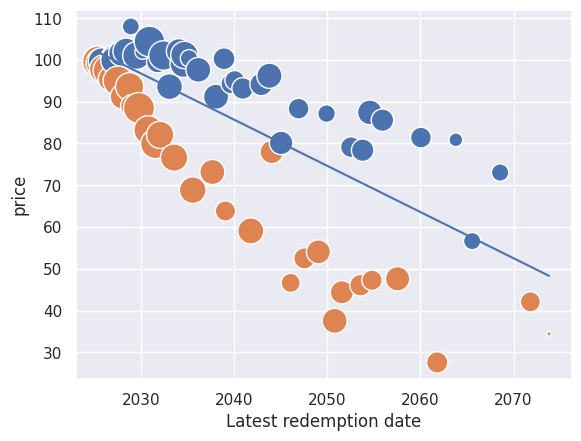

In [14]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=gilts_list,
    x="Latest redemption date",
    y="price",
    size="Amount_Outstanding",
    hue="segmentation",
    legend=False,
    sizes=(10, 500)
)

# show the graph
ax.plot(gilts_list['Latest redemption date'], gilts_list['decision_line'])
plt.show()

In [15]:
gilts_list['yield'] = gilts_list['Sequence'].apply(lambda x: bgs_gilt_yield(bgs_id=x, calc_date=calculation_date))

/tmp/ipykernel_2258/846202552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gilts_list['yield'] = gilts_list['Sequence'].apply(lambda x: bgs_gilt_yield(bgs_id=x, calc_date=calculation_date))


In [16]:
gilts_exc_table = gilts_list.copy()

curve_yield = []
curve_price = []
for _, loo in gilts_exc_table.iterrows():
    exc_list = gilts_exc_table.loc[~gilts_exc_table['ISIN Code'].isin([loo['ISIN Code']])].copy()
    x = np.array(((exc_list['Latest redemption date'] - pd.Timestamp("1970-01-01")).dt.days).to_list())
    y = np.array(exc_list['yield'].to_list())
    epoch_date = np.array((loo['Latest redemption date'] - pd.Timestamp("1970-01-01")).days)
    loo_yld = rates = np.interp(epoch_date, x, y)
    bond = Gilt(
        trade_date=from_iso(calculation_date),
        issue_date=from_iso(loo['Issue date']),
        maturity_date=from_iso(loo['Latest redemption date']),
        first_cpn_date=from_iso(loo['First coupon payable on date']),
        last_cpn_date=from_iso(loo['Latest redemption date']),
        coupon=loo['%']/100,
    )
    fitted_price = bond.price(float(loo_yld))
    curve_price.append(fitted_price)
    curve_yield.append(loo_yld)
gilts_exc_table['curve_yield'] = curve_yield
gilts_exc_table['curve_price'] = curve_price

gilts_exc_table['dislocation'] = (gilts_exc_table['curve_yield'] - gilts_exc_table['yield']).abs()
gilts_exc_table['price_diff'] = (gilts_exc_table['curve_price'] - gilts_exc_table['price']).abs()

closer_gilts = gilts_exc_table.loc[gilts_exc_table['dislocation'] < 0.0005]

x = np.array(((closer_gilts['Latest redemption date'] - pd.Timestamp("1970-01-01")).dt.days).to_list())
y = np.array(closer_gilts['yield'].to_list())

gilt_dates = ((gilts_list['Latest redemption date'] - pd.Timestamp("1970-01-01")).dt.days).to_list()

rates = np.interp(gilt_dates, x, y)

gilts_list['best_crv_yield'] = rates

best_crv_price = []
for _, b in gilts_list.iterrows():
    bond = Gilt(
        trade_date=from_iso(calculation_date),
        issue_date=from_iso(b['Issue date']),
        maturity_date=from_iso(b['Latest redemption date']),
        first_cpn_date=from_iso(b['First coupon payable on date']),
        last_cpn_date=from_iso(b['Latest redemption date']),
        coupon=b['%']/100,
    )
    best_crv_price.append(bond.price(float(b['best_crv_yield'])))
gilts_list['best_crv_price'] = best_crv_price


/tmp/ipykernel_2258/3207076657.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gilts_list['best_crv_yield'] = rates
/tmp/ipykernel_2258/3207076657.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gilts_list['best_crv_price'] = best_crv_price


In [17]:
gilts_list.columns

Index(['Sequence', 'ISIN Code', '%', 'Latest redemption date', 'Issue date',
       'First coupon payable on date', 'Amount_Outstanding', 'price',
       'decision_line', 'segmentation', 'yield', 'best_crv_yield',
       'best_crv_price'],
      dtype='object')

In [18]:
funding_rate = base_rate.loc[base_rate.index==calculation_date]['Rate'][0]

/tmp/ipykernel_2258/4141261149.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  funding_rate = base_rate.loc[base_rate.index==calculation_date]['Rate'][0]


In [19]:
gilt_level_buys = df_buy[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_buys.set_index('Operation date', inplace=True)
gilt_level_buys.index = pd.to_datetime(gilt_level_buys.index, format='%d-%m-%Y').to_period('M').to_timestamp('M')
gilt_level_buys.reset_index(inplace=True)

gilt_buys_ts = gilt_level_buys.pivot_table(
    index='Operation date', 
    columns='ISIN', 
    values='Total allocation (nominal £mn)', aggfunc='sum')

gilt_buys_ts = gilt_buys_ts.fillna(0).cumsum()

gilt_buys_total = gilt_level_buys.reset_index().groupby([ 'ISIN']).agg(
    Total_Allocation_Proceeds=('Total allocation (proceeds £mn)', 'sum'),
    Total_Allocation_Nominal=('Total allocation (nominal £mn)', 'sum'),
    Last_Purchase_Month=('Operation date', 'max')
)
gilt_buys_total.reset_index(inplace=True)


In [20]:
gilt_buys_total.head()

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month
0,GB0002404191,11893.528404,8906.5,2016-10-31
1,GB0004893086,24839.110612,21081.2,2020-10-31
2,GB0008881541,6266.558482,4715.9,2012-04-30
3,GB0008921883,1912.948123,1556.9,2010-01-31
4,GB0008931148,6513.150546,4575.5,2014-03-31


In [21]:
gilts_list.head()

,Sequence,ISIN Code,%,Latest redemption date,Issue date,First coupon payable on date,Amount_Outstanding,price,decision_line,segmentation,yield,best_crv_yield,best_crv_price
356,32010,GB00BK5CVX03,0.625,2025-06-07,2019-07-03,2019-12-07,44622.873,99.628,101.843235,1,0.043268,0.038044,99.679990
357,32025,GB00BTHH2R79,2.0,2025-09-07,2015-03-20,2015-09-07,40343.001,99.264,101.564460,1,0.041302,0.038044,99.375573
358,32026,GB00BPCJD880,3.5,2025-10-22,2023-01-18,2023-04-22,36016.346,99.686,101.428103,0,0.041721,0.038044,99.857158
359,32027,GB00BL68HJ26,0.125,2026-01-30,2020-06-03,2021-01-30,41177.698,97.767,101.125087,1,0.031667,0.038044,97.309396
360,32030,GB00BYZW3G56,1.5,2026-07-22,2016-02-18,2016-07-22,44673.738,97.476,100.600869,1,0.036211,0.038044,97.262141


In [22]:
gilts_list.shape

(66, 13)

In [23]:
gilts_list = gilts_list.merge(gilt_buys_total, left_on='ISIN Code', right_on='ISIN', how='left')

In [24]:
gilts_list.shape

(66, 17)

In [25]:
gilts_list.columns

Index(['Sequence', 'ISIN Code', '%', 'Latest redemption date', 'Issue date',
       'First coupon payable on date', 'Amount_Outstanding', 'price',
       'decision_line', 'segmentation', 'yield', 'best_crv_yield',
       'best_crv_price', 'ISIN', 'Total_Allocation_Proceeds',
       'Total_Allocation_Nominal', 'Last_Purchase_Month'],
      dtype='object')

In [26]:
gilt_level_sales = df_sell[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_sales.set_index('Operation date', inplace=True)
gilt_level_sales.index = pd.to_datetime(gilt_level_sales.index, format='%d-%m-%Y')
gilt_level_sales.reset_index(inplace=True)
gilt_level_sales.head()

,Operation date,ISIN,Total allocation (proceeds £mn),Total allocation (nominal £mn)
0,2022-11-01,GB00BL68HJ26,491.108666,545.0
1,2022-11-01,GB00BYZW3G56,0.000000,0.0
2,2022-11-01,GB00BNNGP668,170.287385,192.8
3,2022-11-01,GB00BDRHNP05,45.194932,50.0
4,2022-11-01,GB00B16NNR78,0.000000,0.0


In [27]:
gilt_sales_date = gilt_level_sales.loc[gilt_level_sales['Operation date']< calculation_date]

In [28]:
gilt_sales_date.groupby(['ISIN']).agg(
    Total_Sales_Proceeds=('Total allocation (proceeds £mn)', 'sum'),
    Total_Sales_Nominal=('Total allocation (nominal £mn)', 'sum'))

,Total_Sales_Proceeds,Total_Sales_Nominal
ISIN,,
GB0002404191,720.880953,646.0
GB0004893086,2731.036971,2584.0
GB0032452392,5597.317757,5491.3
GB00B00NY175,1209.164545,1142.1
GB00B06YGN05,626.651258,695.0
GB00B128DP45,450.902167,459.8
GB00B16NNR78,750.365279,732.3
GB00B1VWPJ53,1256.782628,1247.0
GB00B24FF097,4943.009651,4662.5


In [29]:
gilts_list = gilts_list.merge(
    gilt_sales_date.groupby(['ISIN']).agg(
    Total_Sales_Proceeds=('Total allocation (proceeds £mn)', 'sum'),
    Total_Sales_Nominal=('Total allocation (nominal £mn)', 'sum')
    ), 
    left_on='ISIN', 
    right_on='ISIN', 
    how='left')
gilts_list = gilts_list.fillna(0)


/tmp/ipykernel_2258/236070516.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gilts_list = gilts_list.fillna(0)


In [30]:
focus = gilts_list.loc[(gilts_list['segmentation']==1)&(gilts_list['price']<100)].copy()

### Financing the BoE Loss

In [31]:
# interest paid on the bonds
(focus['Amount_Outstanding']*focus['%']/100).sum()

np.float64(10827.7934575)

In [32]:
focus['Total_Sales_Nominal'].sum()

np.float64(70251.5)

In [33]:
# interest received by boe
((focus['Total_Allocation_Nominal'] - focus['Total_Sales_Nominal'])*focus['%']/100).sum()

np.float64(3704.83875)

In [34]:
# funding cost of the boe
((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*funding_rate/100).sum()

np.float64(16993.679829658588)

In [35]:
total_cost = (focus['Amount_Outstanding']*focus['%']/100).sum() \
- ((focus['Total_Allocation_Nominal'] - focus['Total_Sales_Nominal'])*focus['%']/100).sum() \
+ ((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*funding_rate/100).sum()
total_cost

np.float64(24116.63453715859)

In [36]:
# market holdings
((focus['Amount_Outstanding'] - focus['Total_Allocation_Nominal'] + focus['Total_Sales_Nominal'])*focus['price']/100).sum()

np.float64(467837.30112862)

In [37]:
# boe holdings
((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])).sum()

np.float64(377637.3295479686)

In [38]:
(
    (
        (
            focus['Amount_Outstanding'] - focus['Total_Allocation_Nominal'] + focus['Total_Sales_Nominal']
        )*focus['price']/100 + (
            focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds']
            )
            )*focus['best_crv_yield']
            ).sum()

np.float64(35994.04484669381)

In [39]:
((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*focus['best_crv_yield']).sum()

np.float64(16004.294617463185)

In [40]:
lme_cost = (
    (
        (
            focus['Amount_Outstanding'] - focus['Total_Allocation_Nominal'] + focus['Total_Sales_Nominal']
        )*focus['price']/100 + (
            focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds']
            )
            )*focus['best_crv_yield']
            ).sum() \
     - ((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*focus['best_crv_yield']).sum() \
     + ((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*funding_rate/100).sum()

lme_cost

np.float64(36983.43005888921)

In [41]:
lme_cost_crv = (
    (
        (
            focus['Amount_Outstanding'] - focus['Total_Allocation_Nominal'] + focus['Total_Sales_Nominal']
        )*focus['best_crv_price']/100 + (
            focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds']
            )
            )*focus['best_crv_yield']
            ).sum() \
     - ((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*focus['best_crv_yield']).sum() \
     + ((focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*funding_rate/100).sum()
lme_cost_crv

np.float64(36826.46108351184)

In [42]:
focus['lme_cost_crv'] = (
        (
            focus['Amount_Outstanding'] - focus['Total_Allocation_Nominal'] + focus['Total_Sales_Nominal']
        )*focus['best_crv_price']/100 + (
            focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds']
            )
            )*focus['best_crv_yield'] \
     - (focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*focus['best_crv_yield']\
     + (focus['Total_Allocation_Proceeds'] - focus['Total_Sales_Proceeds'])*funding_rate/100


<Axes: ylabel='Frequency'>

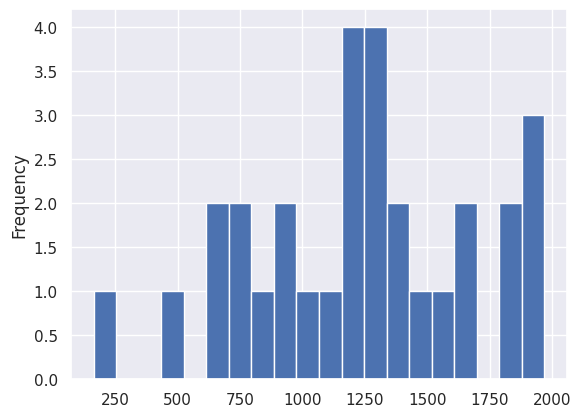

In [43]:
focus['lme_cost_crv'].plot.hist(bins=20)

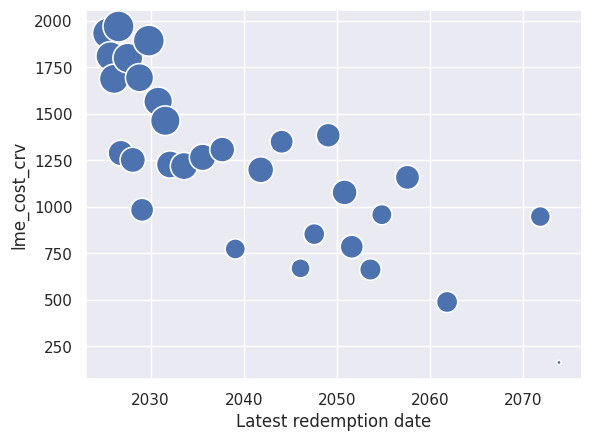

In [44]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=focus,
    x="Latest redemption date",
    y="lme_cost_crv",
    size="Amount_Outstanding",
    hue="segmentation",
    legend=False,
    sizes=(10, 500)
)

In [45]:
(focus['Total_Allocation_Nominal']==0).sum()

np.int64(2)

In [46]:
focus.loc[focus['Total_Allocation_Nominal']==0]

,Sequence,ISIN Code,%,Latest redemption date,Issue date,First coupon payable on date,Amount_Outstanding,price,decision_line,segmentation,yield,best_crv_yield,best_crv_price,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,Total_Sales_Proceeds,Total_Sales_Nominal,lme_cost_crv
23,32190,GB00BM8Z2T38,1.000,2032-01-31,2021-12-02,2022-01-31,36801.371,82.066,94.482975,1,0.040639,0.040639,82.066000,0,0.0,0.0,0,0.0,0.0,1227.360051
65,32297,GB00BLBDX619,1.125,2073-10-22,2022-02-09,2022-04-22,11111.000,34.420,48.303329,1,0.044186,0.051158,28.730494,0,0.0,0.0,0,0.0,0.0,163.309787


In [47]:
focus.sort_values('lme_cost_crv', ascending=False)

,Sequence,ISIN Code,%,Latest redemption date,Issue date,First coupon payable on date,Amount_Outstanding,price,decision_line,segmentation,yield,best_crv_yield,best_crv_price,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,Total_Sales_Proceeds,Total_Sales_Nominal,lme_cost_crv
4,32030,GB00BYZW3G56,1.500,2026-07-22,2016-02-18,2016-07-22,44673.738,97.476,100.600869,1,0.036211,0.038044,97.262141,GB00BYZW3G56,30868.754478,28807.6,2020-09-30 00:00:00,1327.033864,1429.2,1969.344469
0,32010,GB00BK5CVX03,0.625,2025-06-07,2019-07-03,2019-12-07,44622.873,99.628,101.843235,1,0.043268,0.038044,99.679990,GB00BK5CVX03,29642.380320,28835.4,2021-10-31 00:00:00,0.000000,0.0,1932.601707
17,32125,GB00BJMHB534,0.875,2029-10-22,2019-06-19,2019-10-22,44643.059,88.474,97.001039,1,0.036927,0.037551,88.235981,GB00BJMHB534,30443.805292,28641.7,2021-12-31 00:00:00,1243.469336,1473.6,1893.029108
1,32025,GB00BTHH2R79,2.000,2025-09-07,2015-03-20,2015-09-07,40343.001,99.264,101.564460,1,0.041302,0.038044,99.375573,GB00BTHH2R79,28331.999026,26198.3,2020-06-30 00:00:00,0.000000,0.0,1809.699008
8,32040,GB00BDRHNP05,1.250,2027-07-22,2017-03-15,2017-07-22,41947.822,94.976,99.494861,1,0.036182,0.037582,94.688974,GB00BDRHNP05,28722.358543,27135.7,2021-12-31 00:00:00,3380.399996,3707.7,1799.432536
13,32075,GB00BFX0ZL78,1.625,2028-10-22,2018-03-16,2018-10-22,38743.345,93.590,98.107047,1,0.036037,0.036037,93.589998,GB00BFX0ZL78,28054.098274,25173.7,2021-11-30 00:00:00,3468.782326,3846.7,1693.747097
3,32027,GB00BL68HJ26,0.125,2026-01-30,2020-06-03,2021-01-30,41177.698,97.767,101.125087,1,0.031667,0.038044,97.309396,GB00BL68HJ26,21831.148665,21911.7,2021-12-31 00:00:00,1860.103740,2048.1,1687.750539
19,32127,GB00BL68HH02,0.375,2030-10-22,2020-05-13,2020-10-22,39816.747,83.208,95.895030,1,0.038009,0.038542,82.972554,GB00BL68HH02,23596.552703,23714.6,2021-12-31 00:00:00,2471.750917,3150.2,1566.294838
21,32175,GB00BMGR2809,0.250,2031-07-31,2020-11-12,2021-01-31,41587.911,79.919,95.040525,1,0.039008,0.039775,79.547253,GB00BMGR2809,12911.244420,13632.3,2021-12-31 00:00:00,1113.912011,1490.4,1462.553373
48,32257,GB00BFWFPP71,1.750,2049-01-22,2018-09-12,2019-01-22,30932.767,54.050,75.692950,1,0.051158,0.051158,54.050001,GB00BFWFPP71,23101.172338,18472.1,2021-12-31 00:00:00,102.579750,175.0,1384.326171


### Exchanging the Bonds

In [48]:
focus.columns

Index(['Sequence', 'ISIN Code', '%', 'Latest redemption date', 'Issue date',
       'First coupon payable on date', 'Amount_Outstanding', 'price',
       'decision_line', 'segmentation', 'yield', 'best_crv_yield',
       'best_crv_price', 'ISIN', 'Total_Allocation_Proceeds',
       'Total_Allocation_Nominal', 'Last_Purchase_Month',
       'Total_Sales_Proceeds', 'Total_Sales_Nominal', 'lme_cost_crv'],
      dtype='object')

In [49]:
(focus['Amount_Outstanding']*focus['%']/100 - focus['Amount_Outstanding']*focus['price']/100*focus['best_crv_yield'])

0    -1412.418799
1     -716.647841
3    -1480.105738
4     -986.559013
5    -1096.252390
8     -972.927820
10   -1078.679719
13    -677.132616
15    -821.656236
17   -1092.563209
19   -1127.616614
21   -1218.023339
23    -859.346341
26    -886.551929
31    -867.123607
33    -534.855434
36    -473.215321
40    -569.017282
43    -213.617242
45    -353.929131
47    -309.320714
48    -314.000161
50    -422.987474
51    -301.263646
53    -230.598093
56    -199.309424
58    -215.560354
60    -241.203526
64    -130.485578
65     -70.651313
dtype: float64

In [50]:
(focus['Total_Allocation_Nominal'] - focus['Total_Sales_Nominal'])*(focus['price']/100*focus['best_crv_yield']- focus['%']/100)

0     912.708176
1     465.383206
3     713.984263
4     604.614892
5     187.030493
8     543.383467
10    287.845523
13    372.740333
15     15.379597
17    664.893204
19    582.387082
21    355.610975
23      0.000000
26      8.160979
31    243.291564
33    166.657269
36      0.000000
40    140.384320
43     48.801175
45     84.846845
47     77.344784
48    185.734834
50    155.125804
51     18.656905
53      0.125884
56     82.683353
58     66.106560
60      0.785704
64     22.157191
65      0.000000
dtype: float64

In [51]:
focus['carry_chg']=((focus['Amount_Outstanding']*focus['%']/100 - focus['Amount_Outstanding']*focus['price']/100*focus['best_crv_yield']) \
+ (focus['Total_Allocation_Nominal'] - focus['Total_Sales_Nominal'])*(focus['price']/100*focus['best_crv_yield']- focus['%']/100))

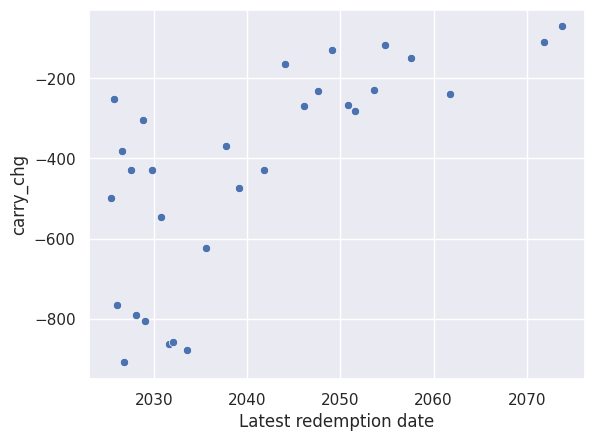

In [52]:
ax = sns.scatterplot(
    data=focus,
    x="Latest redemption date",
    y="carry_chg"
)

In [75]:
focus.loc[focus['Latest redemption date'] > pd.to_datetime("2035-01-01")]['carry_chg'].sum()

np.float64(-4154.436108603709)

In [76]:
long_focus = focus.loc[
    (focus['Latest redemption date'] > pd.to_datetime("2035-01-01") ) \
    & ((focus['yield'] - focus['best_crv_yield']).abs() > 0.0005)
    ]

In [77]:
(long_focus['Amount_Outstanding']*(1-long_focus['price']/100)).sum()

np.float64(77688.027678)

In [78]:
gilts_list['Amount_Outstanding'].sum()

np.float64(2048183.6959999998)

In [79]:
(long_focus['yield'] - long_focus['best_crv_yield']).abs() > 0.0005

50    True
58    True
60    True
64    True
65    True
dtype: bool

In [80]:
long_focus['carry_chg'].sum()

np.float64(-836.7129851167675)